In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

sns.set_theme()

In [2]:
df = pd.read_csv('dataset/full_wage.csv', index_col='Unnamed: 0')
X = df.drop(['WAGE'],axis=1)
display(X.head(3))
y = df['WAGE']

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Предобработка числовых переменных.

Сделам сразу предобработку для корректной работы с коэффициентами.

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns =   ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
).set_output(transform="pandas")


In [5]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [6]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

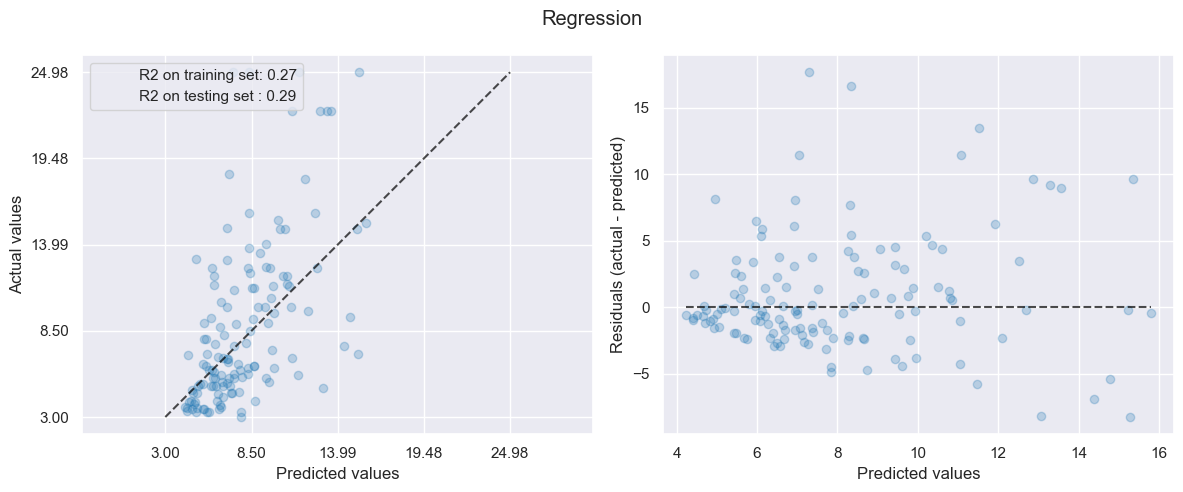

In [7]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

In [8]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    {"Coefficients": model[-1].regressor_.coef_, 
     'Std': model[:-1].transform(X_train).std(axis=0).values},
     index=feature_names    
)

coefs

,Coefficients,Std
RACE_Hispanic,-0.013529,0.223312
RACE_Other,-0.009086,0.336725
RACE_White,0.022584,0.386740
OCCUPATION_Clerical,0.000128,0.398611
OCCUPATION_Management,0.090610,0.319421
OCCUPATION_Other,-0.025019,0.449561
OCCUPATION_Professional,0.072046,0.396697
OCCUPATION_Sales,-0.046554,0.246835
OCCUPATION_Service,-0.090971,0.355048
SECTOR_Construction,-0.000213,0.212972


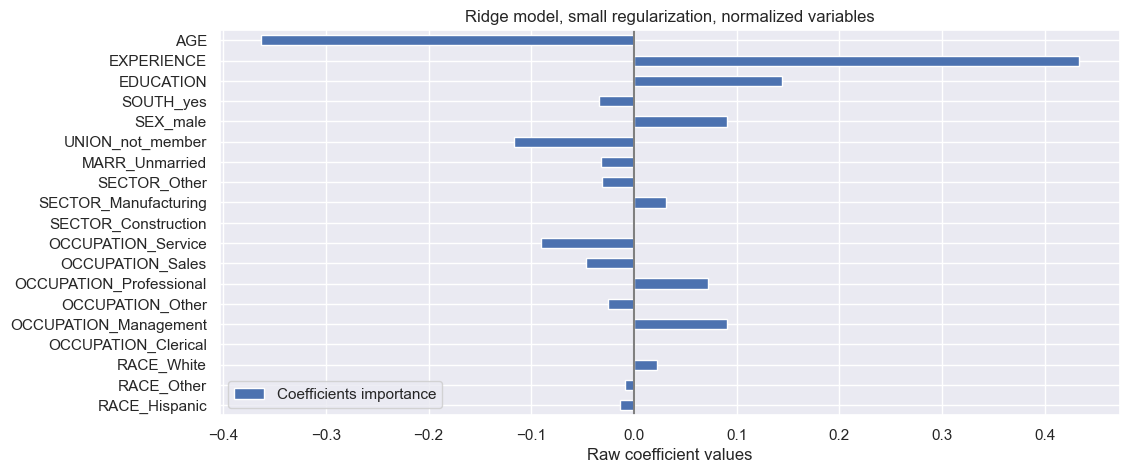

In [9]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(15, 5))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [10]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

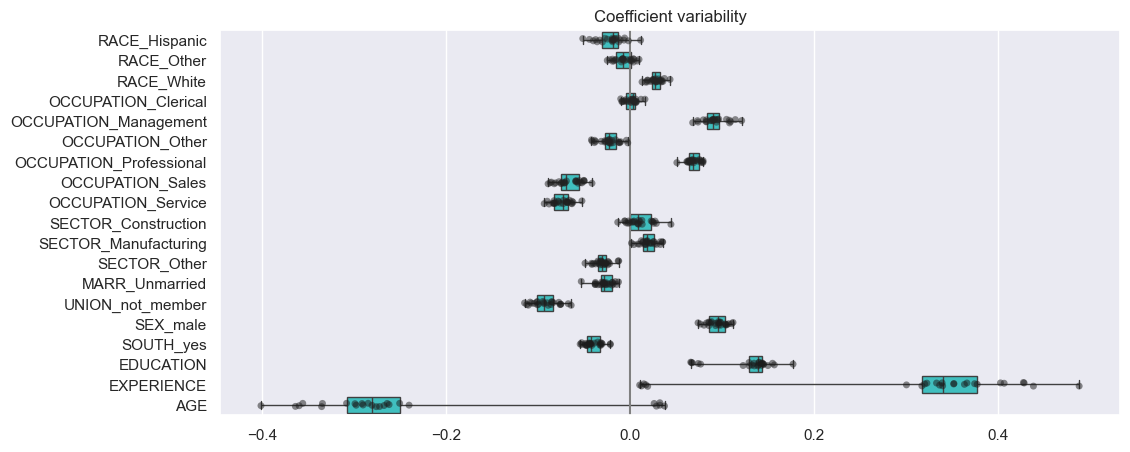

In [11]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

Результат из-за мультикорреляции похож на предидущий ненормализованный случай.

## Регуляризация линейных моделей

В машинном обучении регрессия `Ridge` чаще используется с регуляризацией, которое имеет достаточно значисое значение.

Ранее регуляризация, в нашем примере, практически отсутствовала. Регуляризация улучшает условия задачи и уменьшает дисперсию оценок. `Ridge CV` применяет перекрестную проверку, чтобы подобрать значение параметра регуляризации (`alpha`), что бы улучшить качество модели.

In [12]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 15, 26)  # перебор alpha на валидации
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13,
       1.e+14, 1.e+15]))))])

In [13]:
model[-1].regressor_.alpha_

10.0

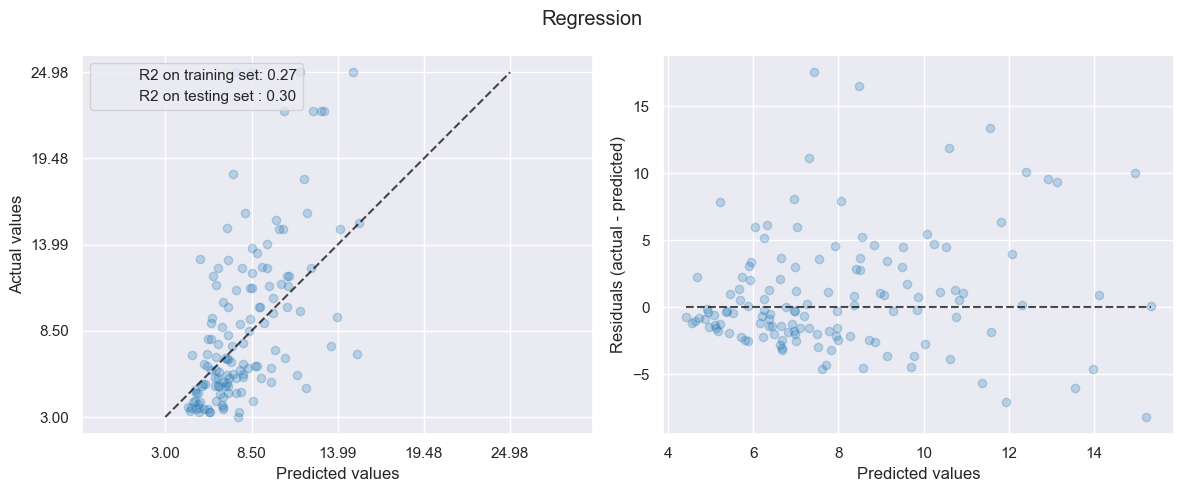

In [14]:
y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

Способность регуляризованной модели к предсказанию несколько лучше способности нерегуляризованной модели.

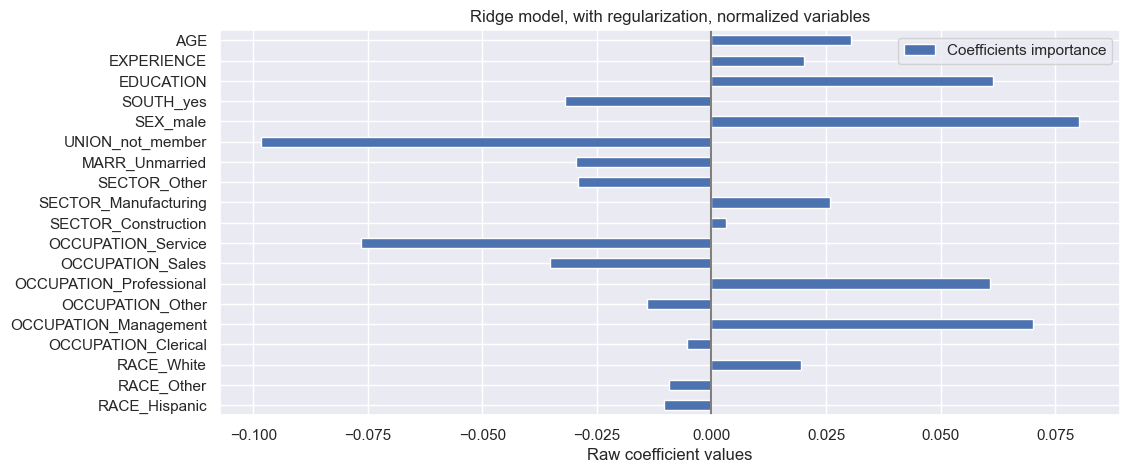

In [15]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(15, 5))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Коэффициенты существенно отличаются. 

Коэффициенты AGE и EXPERIENCE являются положительными, но теперь они оказывают меньшее влияние на прогноз.

Регуляризация уменьшает влияние коррелирующих переменных на модель, поскольку вес распределяется между двумя прогностическими переменными, поэтому ни одна из них по отдельности не будет иметь большого веса.

С другой стороны, веса, полученные с помощью регуляризации, более стабильны. Эта стабильность видна из графика, полученного на основе анализа стандартных отклонений при перекрестной проверке. Этот график можно сравнить с предыдущим.

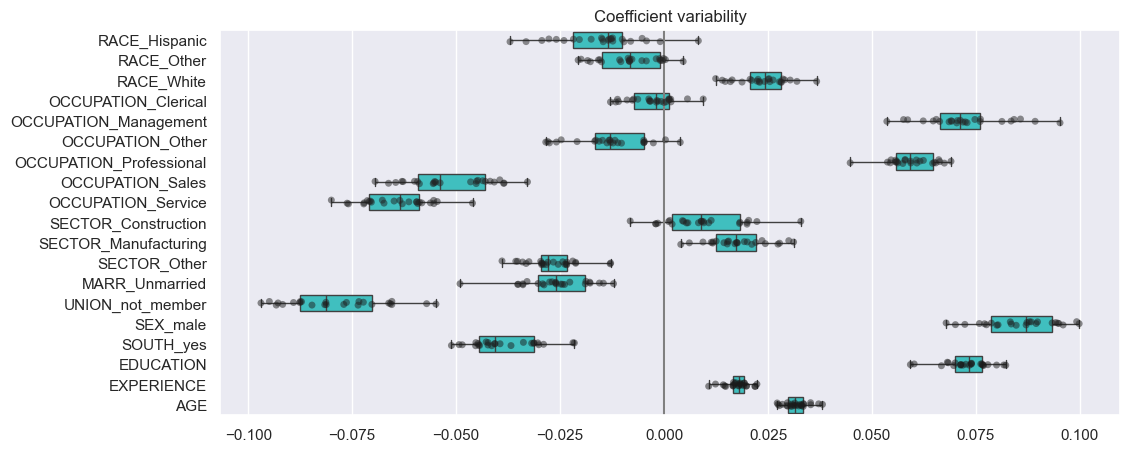

In [16]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

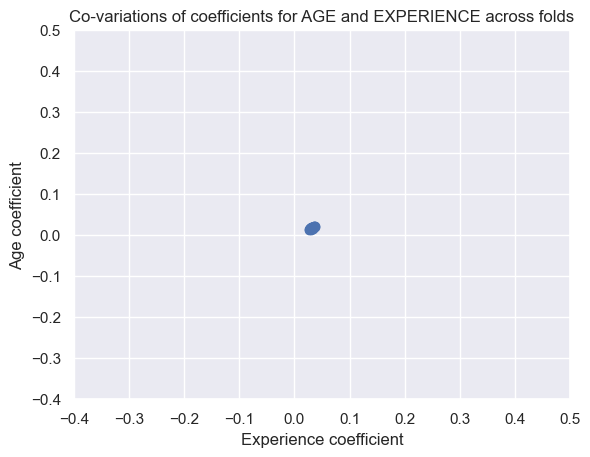

In [17]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

## Линейные модели с разреженными коэффициентами

Другой возможностью учесть коррелированные переменные в наборе данных является оценка разреженных коэффициентов. В некотором роде мы уже делали это вручную, когда удаляли столбец ВОЗРАСТА в предыдущей оценке гребневой регресии.

In [18]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 15, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=...
                                            regressor=LassoCV(alphas=array([1.00000000e-10, 1.77827941e-09, 3.16227766e-08, 5.62341325e-07,
       1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00, 1.77827941e+01, 3.16227766e+02, 5.62341325e+03,
       1.00000000e+05, 1.77827941e+06, 3.16227766e+07, 5.62341325e+08,
       1.00000000e+10, 1.77827941e+11, 3.16227766e+12, 5.62341325e+13,
       1.00000000e+15]),
                                                              max_iter=100000)))])

In [19]:
model[-1].regressor_.alpha_

0.0031622776601683794

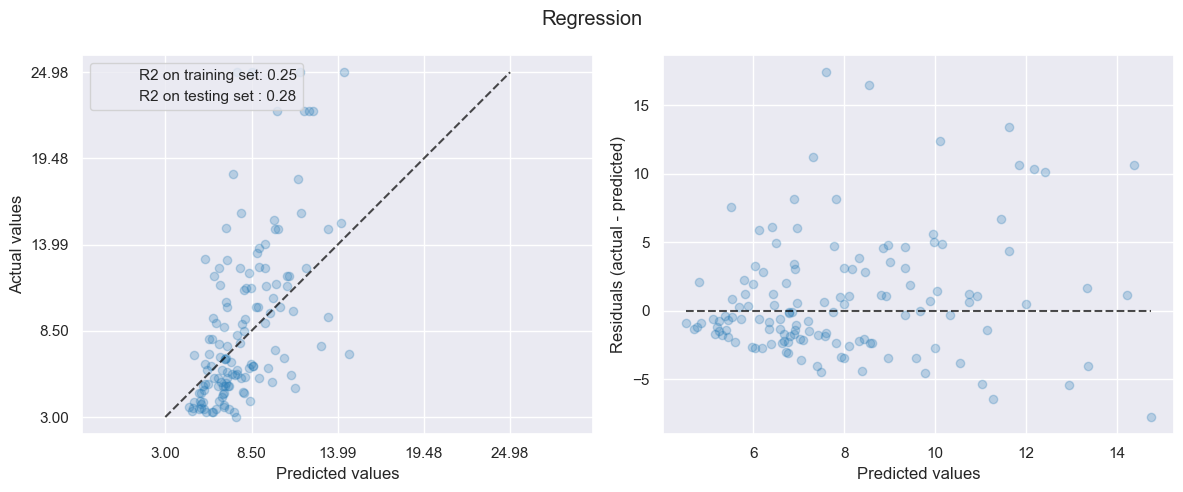

In [20]:
y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

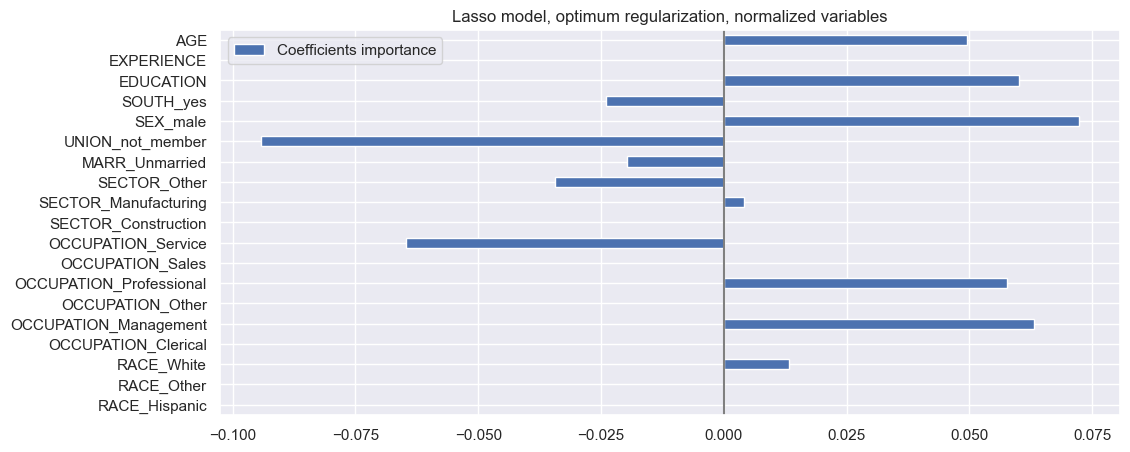

In [21]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(15, 5))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Модель Lasso определяет корреляцию между AGE и EXPERIENCE и подавляет один из них для получения прогноза.

Важно иметь в виду, что коэффициенты, которые были отброшены, все еще могут быть связаны с результатом сами по себе: модель решила исключить их, поскольку они не дают дополнительной информации в дополнение к другим характеристикам. 

***Кроме того, этот выбор нестабилен для коррелирующих признаков, и его следует интерпретировать с осторожностью.***

Действительно, мы можем проверить разброс коэффициентов для разных признаков.

In [22]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

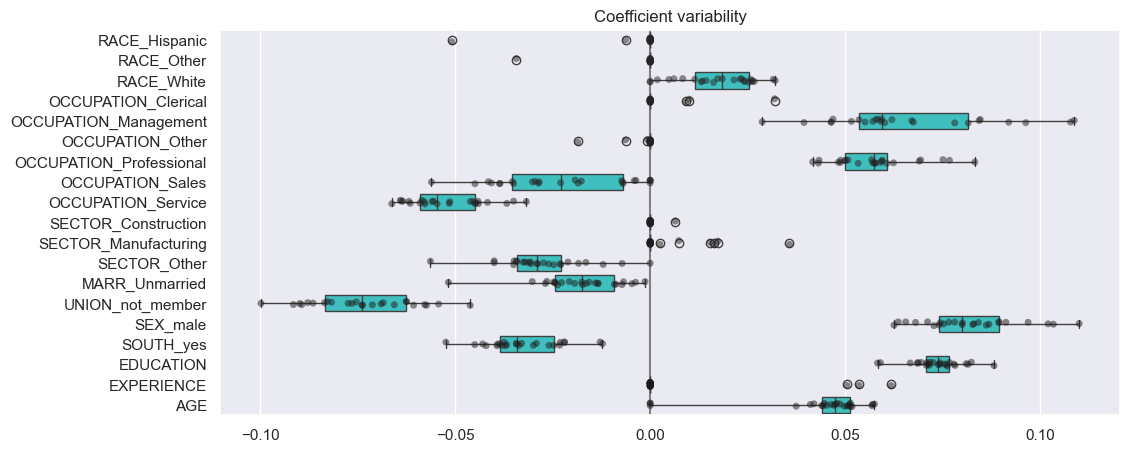

In [23]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

### Важные замечания

**Неверная причинно-следственная интерпретация**

Политиков может интересовать степень влиянии образования людей на заработную плату, чтобы оценить, будет ли иметь экономический смысл определенная политика, направленная на то, чтобы побудить людей получать дополнительное образование. 

**Хотя модели машинного обучения отлично подходят для измерения статистических взаимосвязей, но они, как правило, неспособны выявить причинно-следственные связи.**

Может возникнуть желание посмотреть на зависимость образования от заработной платы в нашей последней модели (или любой другой модели, если уж на то пошло) и прийти к выводу, что она отражает истинное влияние изменения стандартизированной переменной образования на заработную плату.

К сожалению, вероятно, существуют ненаблюдаемые переменные, которые либо завышают, либо занижают значение этого коэффициента. Переменная, влияющая на образование и заработную плату, вероятно, не учитывается. 

Одним из примеров такой переменной являются "способности" человека. Предположительно, более способные люди с большей вероятностью получат образование и в то же время с большей вероятностью будут получать более высокую почасовую заработную плату на любом уровне образования. В этом случае способность вызывает положительное смещение пропущенной переменной (OVB) на коэффициент EDUCATION, тем самым преувеличивая влияние образования на заработную плату.

Давайте посмотрим на неспособность машинного обучения вывести причинно-следственные связи для смоделированного случая `ability`.

### Синтетические данные

1. опыт работы в годах и показатель способностей рассчитываются на основе нормального распределения; 
2. почасовая заработная плата одного из родителей рассчитывается на основе бета-распределения;
3. затем мы создаем показатель степени бакалавра, на который положительно влияют способности и почасовая заработная плата родителей.
4. далее моделируем почасовую заработную плату как линейную функцию всех предыдущих переменных и случайной составляющей.

Обратите внимание, что все переменные положительно влияют на почасовую заработную плату.

In [29]:
import numpy as np
import pandas as pd

n_samples = 10_000
rng = np.random.RandomState(32)

experiences = rng.normal(20, 10, size=n_samples).astype(int)
experiences[experiences < 0] = 0
abilities = rng.normal(0, 0.15, size=n_samples)
parent_hourly_wages = 50 * rng.beta(2, 8, size=n_samples)
parent_hourly_wages[parent_hourly_wages < 0] = 0
college_degrees = (
    9 * abilities + 0.02 * parent_hourly_wages + rng.randn(n_samples) > 0.7
).astype(int)

true_coef = pd.Series(
    {
        "college degree": 2.0, 
        "ability": 5.0,
        "experience": 0.2,
        "parent hourly wage": 1.0,
    }
)
hourly_wages = (
    true_coef["experience"] * experiences
    + true_coef["parent hourly wage"] * parent_hourly_wages
    + true_coef["college degree"] * college_degrees
    + true_coef["ability"] * abilities
    + rng.normal(0, 1, size=n_samples)
)

hourly_wages[hourly_wages < 0] = 0

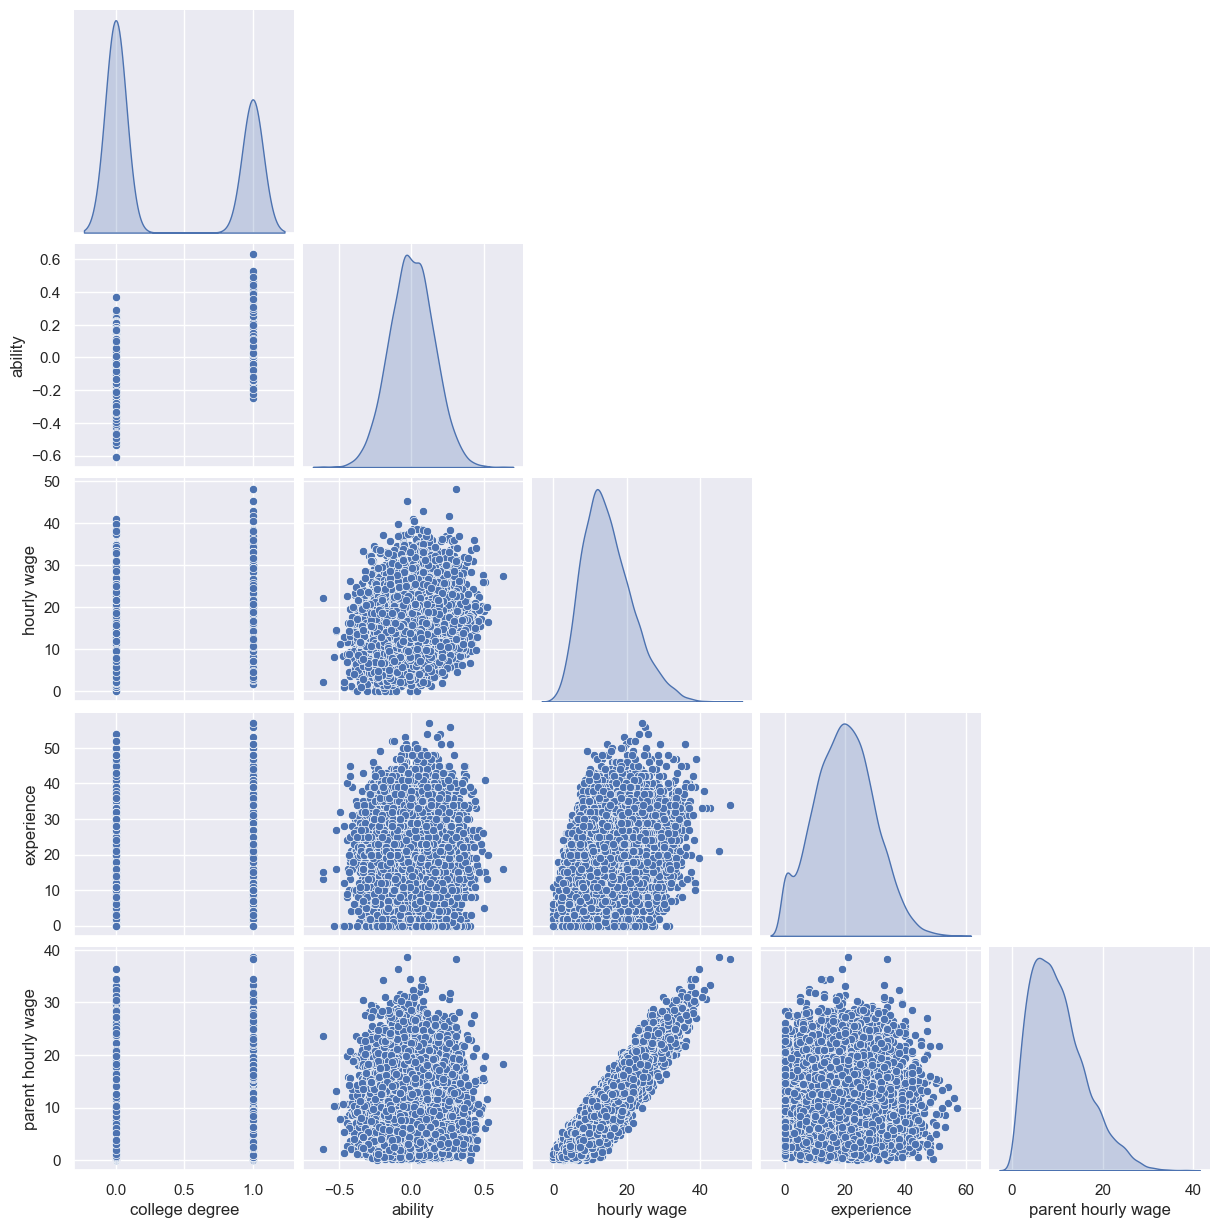

In [30]:
import seaborn as sns

df = pd.DataFrame(
    {
        "college degree": college_degrees,
        "ability": abilities,
        "hourly wage": hourly_wages,
        "experience": experiences,
        "parent hourly wage": parent_hourly_wages,
    }
)

grid = sns.pairplot(df, diag_kind="kde", corner=True)

In [31]:
from sklearn.model_selection import train_test_split

target_name = "hourly wage"
X, y = df.drop(columns=target_name), df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Прогнозирование дохода с учетом всех наблюдаемых переменных

Построим простую модель на базе линейной регрессии, предпологая, что все переменные важны.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features_names = ["experience", "parent hourly wage", "college degree", "ability"]

regressor_with_ability = LinearRegression()
regressor_with_ability.fit(X_train[features_names], y_train)
y_pred_with_ability = regressor_with_ability.predict(X_test[features_names])
R2_with_ability = r2_score(y_test, y_pred_with_ability)

print(f"R2 score with ability: {R2_with_ability:.3f}")

R2 score with ability: 0.977


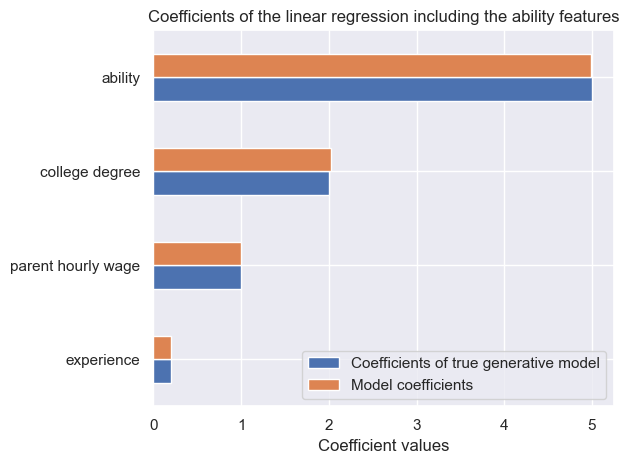

In [33]:
import matplotlib.pyplot as plt

model_coef = pd.Series(regressor_with_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
ax.set_title("Coefficients of the linear regression including the ability features")
_ = plt.tight_layout()

### Прогнозирование дохода с частичными наблюдениями

In [34]:
features_names = ["experience", "parent hourly wage", "college degree"]

regressor_without_ability = LinearRegression()
regressor_without_ability.fit(X_train[features_names], y_train)
y_pred_without_ability = regressor_without_ability.predict(X_test[features_names])
R2_without_ability = r2_score(y_test, y_pred_without_ability)

print(f"R2 score without ability: {R2_without_ability:.3f}")

R2 score without ability: 0.970


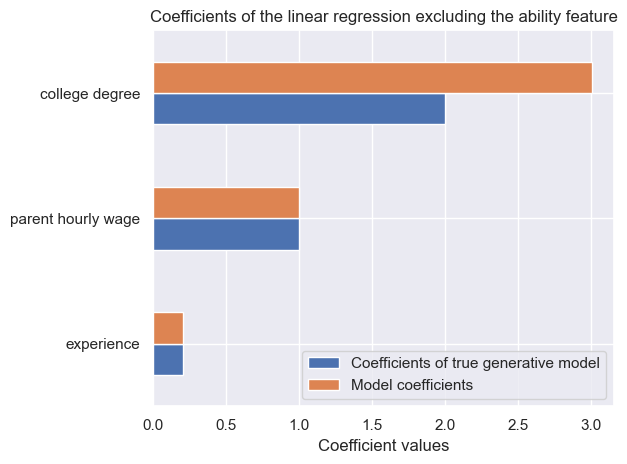

In [35]:
model_coef = pd.Series(regressor_without_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
_ = ax.set_title("Coefficients of the linear regression excluding the ability feature")
plt.tight_layout()
plt.show()

Чтобы компенсировать пропущенную переменную, модель увеличивает коэффициент для характеристики `college degree`. Следовательно, интерпретация этого значения коэффициента как причинно-следственной связи с истинной генеративной моделью неверна.